In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

*Made by Alessandro Ciocchetti, Gwydyon Marchelli, Olga Cozzolino, Lorena Volpini, Davide Bottinelli*

In [49]:
import numpy as np
import csv
from scipy.stats import mode, kurtosis, skew, normaltest, iqr
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import mode
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Optional: baseline comparison
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#to remove warnings from the code
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)


In [50]:
file=open('C:/Users/sudha/Downloads/MA336 Final/dataset.xls')
originaldata = pd.read_csv(file)
file.close()

In [121]:
labels = originaldata.label.unique()
header = list(originaldata)
originaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   filename            1000 non-null   object 
 1   chroma_stft         1000 non-null   float64
 2   rmse                1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

**Functions**

In [130]:
# Distribution of the raw variables 

def plot_hists(column,ylimit = 1, binnumb = 10):
  fig, ax = pl.subplots(1,10,figsize=(40,3))
  fig.tight_layout()
  bins= np.arange(min(originaldata[column]),max(originaldata[column]), (max(originaldata[column])-min(originaldata[column]))/binnumb)
  for j in range(1):
    for i in range(10):
      labeledData = originaldata[originaldata['label'] == labels[j+(j+i)]][column]
      ax[i].hist(labeledData,bins,weights=np.ones(len(labeledData)) / len(labeledData), rwidth = 0.7)
      ax[i].set_title(labels[j+(j+i)])
      ax[i].yaxis.set_major_formatter(PercentFormatter(1))
  
  if min(originaldata[column])>=0:
    custom_xlim = (0, max(originaldata[column])) 
  else:
    custom_xlim = (min(originaldata[column]), max(originaldata[column])) 
  custom_ylim = (0, ylimit)
  # Setting the values for all axes.
  pl.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
  pl.suptitle(column,fontweight='bold')
  fig.subplots_adjust(top=0.9)

  # Boxplot and outliers viz

def plot_box(column,r,c):
  fig, ax = pl.subplots(r,c,figsize=(10,10))
  fig.tight_layout()

  for j in range(r):
    for i in range(c):
      labeledData = column
      ax[j,i].boxplot(labeledData)
      
  pl.suptitle(header[i],fontweight='bold')
  fig.subplots_adjust(top=0.9)



def generalStatist(column, label = None, outliers = None):
  if label == None:
    labeledData = originaldata[column]
  else:
    labeledData = originaldata[originaldata['label'] == label][column]
  output = {"media" : np.mean(labeledData), "mediana" : np.median(labeledData),"moda" : mode(labeledData),"standard_dev" : np.std(labeledData),"iqr" : iqr(labeledData),"kurtosis" : kurtosis(labeledData), "skewness" : skew(labeledData), "normal_test" : normaltest(labeledData)}
  return output


# list of the outliers of the input column
def outliers(data):
    arr=[]
    q1=np.percentile(data,25)
    q3=np.percentile(data,75)
    iqr=q3-q1
    mi=q1-(1.5*iqr)
    ma=q3+(1.5*iqr)
    for i in list(data):
        if i<mi:
            arr.append(i)
        elif i>ma:
            arr.append(i)
    return arr


**Correlations**

In [131]:
def scatter(col1, col2):
    '''Scatterplot tra due variabili. '''
    pl.scatter(col1, col2)
    pl.xlabel(col1)
    pl.ylabel(col2)
    pl.show()
    

def correlation(cols):
    '''Compute correlations between variables, considering cols as all the columns to be explorated'''   
    corr = cols.corr(method= 'spearman')
    return corr

def lin_regr_eq(x, y, n = 1):
    '''Study dependencies between variables. n degree of regression, default = 1'''
    coefs = np.polyfit(x, y, deg = n)
    p = np.poly1d(coefs)
    r2 = r2_score(y, p(x))
    print(" ", p, "\n", "r2= ", r2)

In [54]:
originaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   filename            1000 non-null   object 
 1   chroma_stft         1000 non-null   float64
 2   rmse                1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

In [55]:
originaldata.describe(include='all')

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000
unique,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
top,blues.00000.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
mean,NaN,0.378669,0.130929,2201.834226,2242.559613,4571.702159,0.103637,-144.479170,99.552199,-8.921949,...,4.471604,-4.797232,1.781547,-3.870276,1.147988,-3.967431,0.507303,-2.328779,-1.094875,NaN
std,NaN,0.081706,0.065685,715.961347,526.337663,1574.770035,0.041834,100.235659,31.331904,21.695015,...,6.717312,6.170919,5.009489,4.874423,4.579110,4.550650,3.869088,3.755574,3.837561,NaN
min,NaN,0.171782,0.005276,569.930721,897.994319,749.062137,0.021701,-552.064026,-1.527147,-89.901138,...,-15.805225,-27.542309,-12.598773,-17.545473,-15.693589,-17.227766,-11.975698,-18.504187,-19.935202,NaN
25%,NaN,0.319641,0.086625,1627.793931,1907.136505,3380.956639,0.070281,-200.695129,76.811485,-24.223789,...,-0.551576,-9.363372,-1.640080,-7.164838,-1.857098,-7.194296,-2.003978,-4.670281,-3.367999,NaN
50%,NaN,0.383075,0.122448,2209.468780,2221.408983,4658.671830,0.099539,-120.206070,98.452553,-10.716073,...,3.891842,-4.199810,1.879423,-3.614473,1.211945,-4.059109,0.669789,-2.391261,-1.155198,NaN
75%,NaN,0.435974,0.175793,2691.969702,2578.474352,5534.197785,0.132007,-73.895018,119.893629,5.505793,...,9.706133,-0.161017,5.155263,-0.323536,4.350694,-0.842968,3.112519,0.149070,1.303739,NaN


In [56]:
originaldata.isnull().sum()

filename              0
chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
label                 0
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

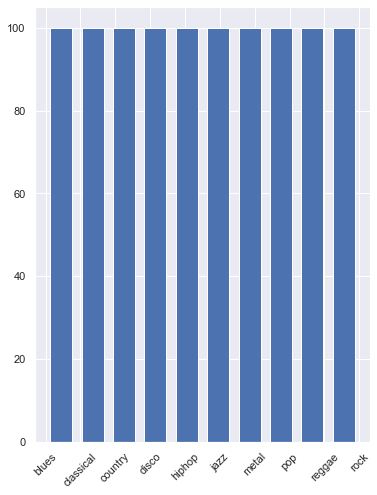

In [57]:
bin = 10

pl.hist(originaldata["label"], bins = bin, rwidth = 0.7)
pl.xticks(rotation=45)

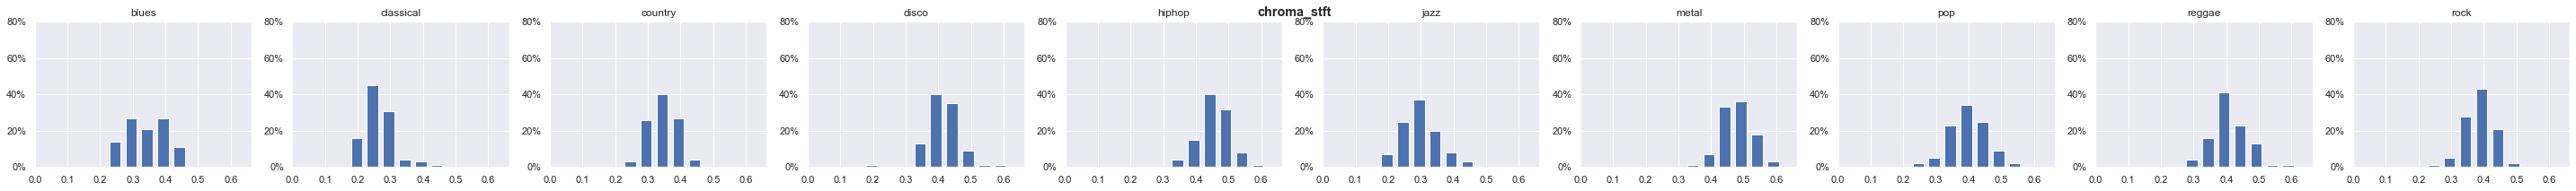

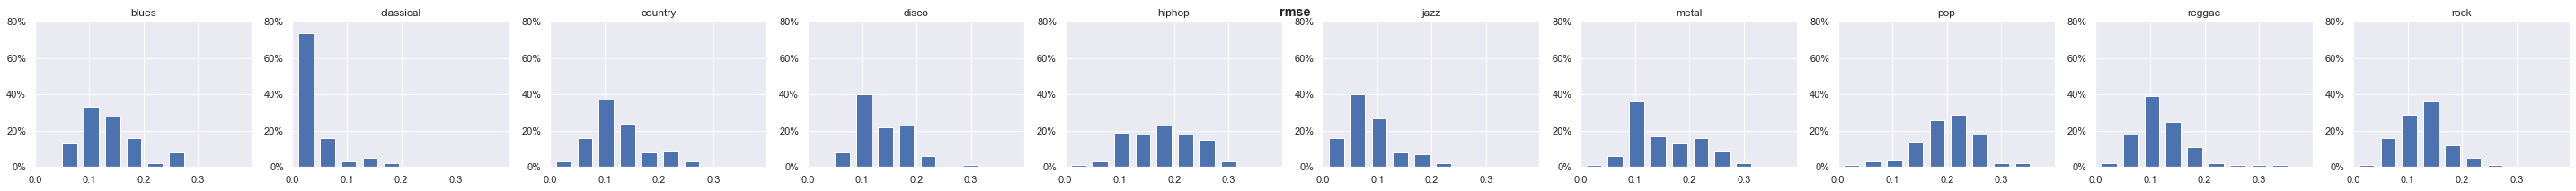

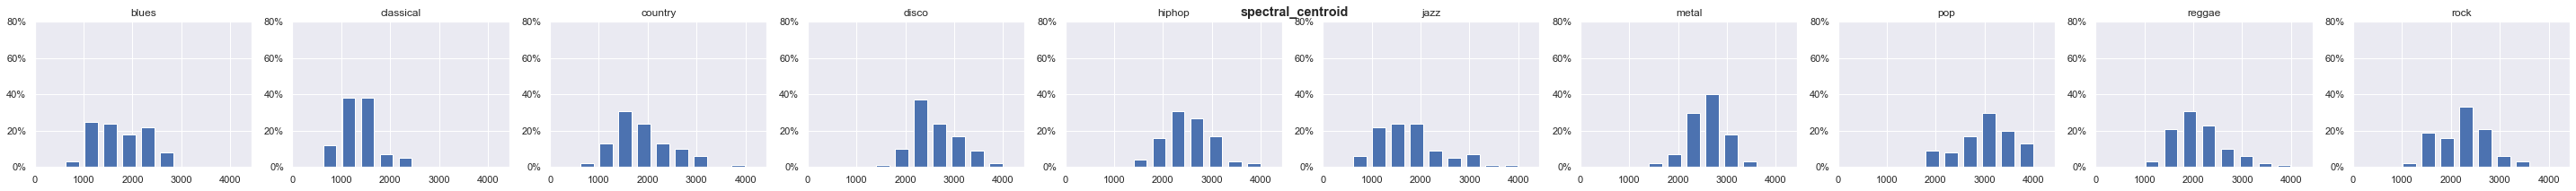

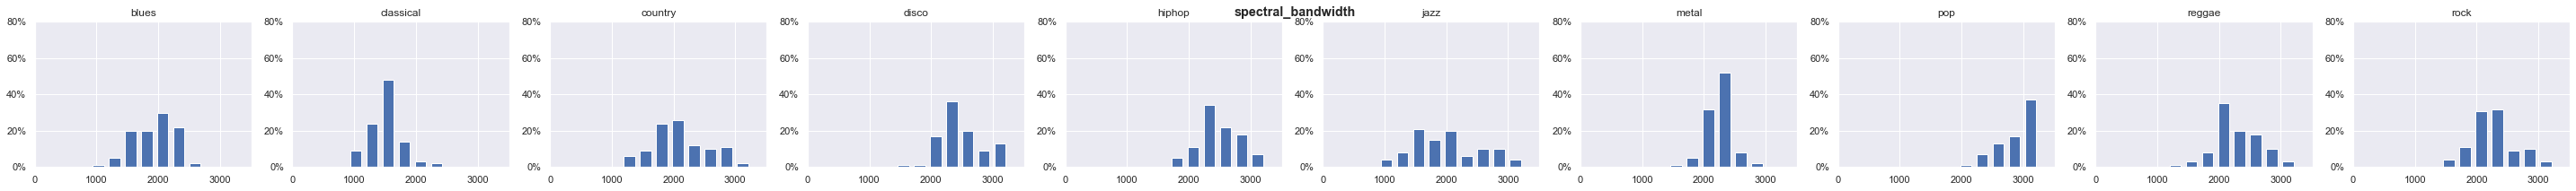

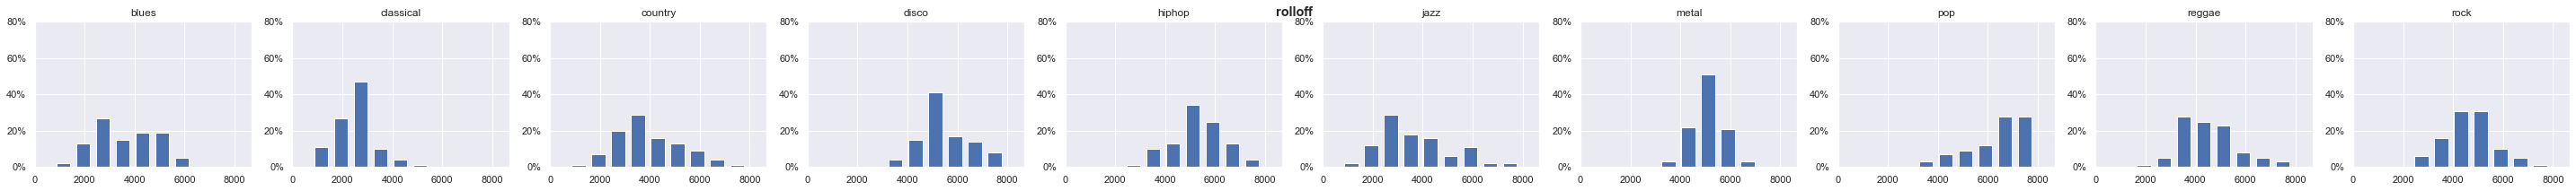

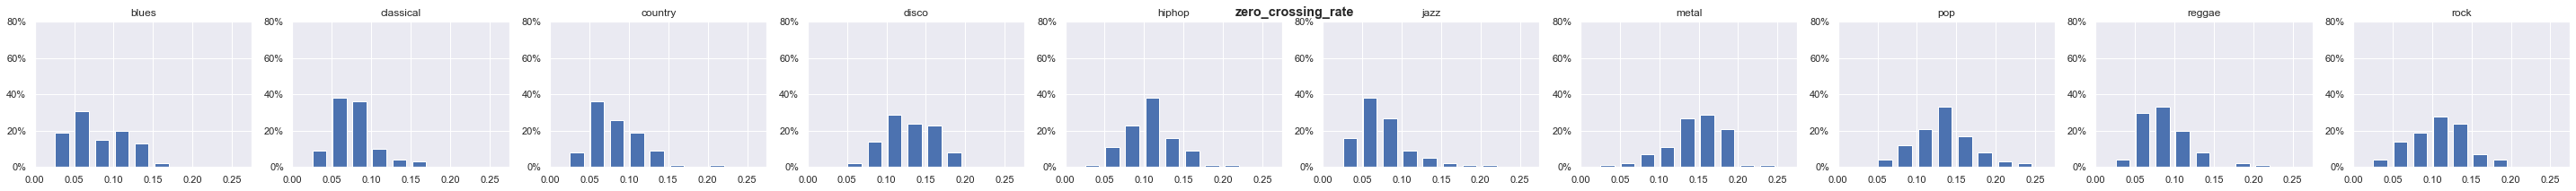

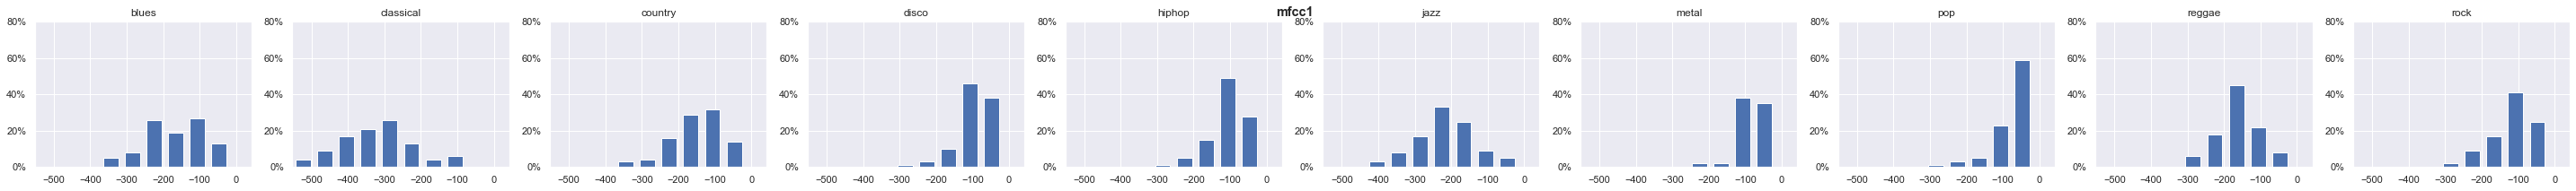

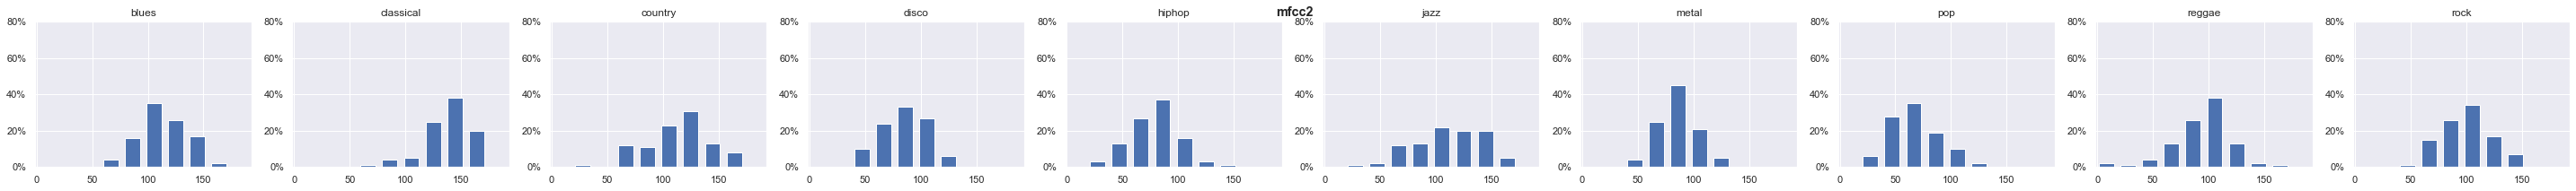

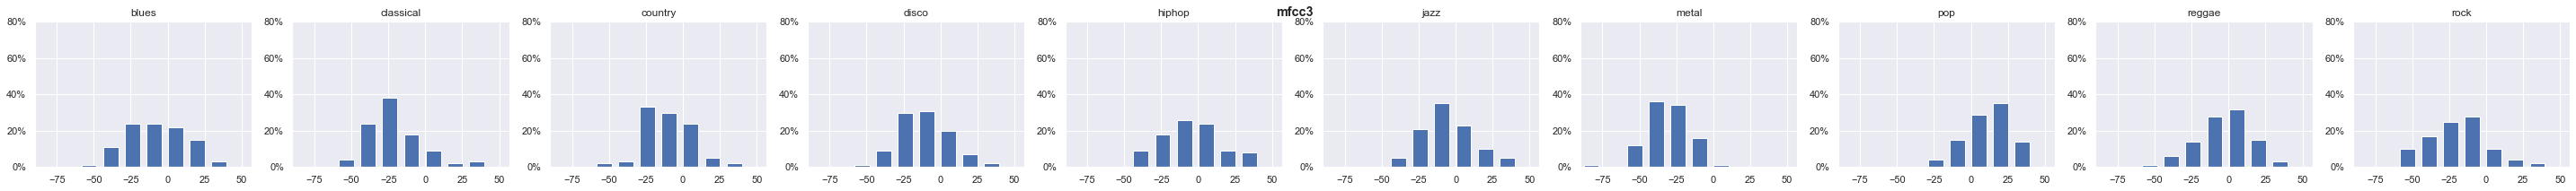

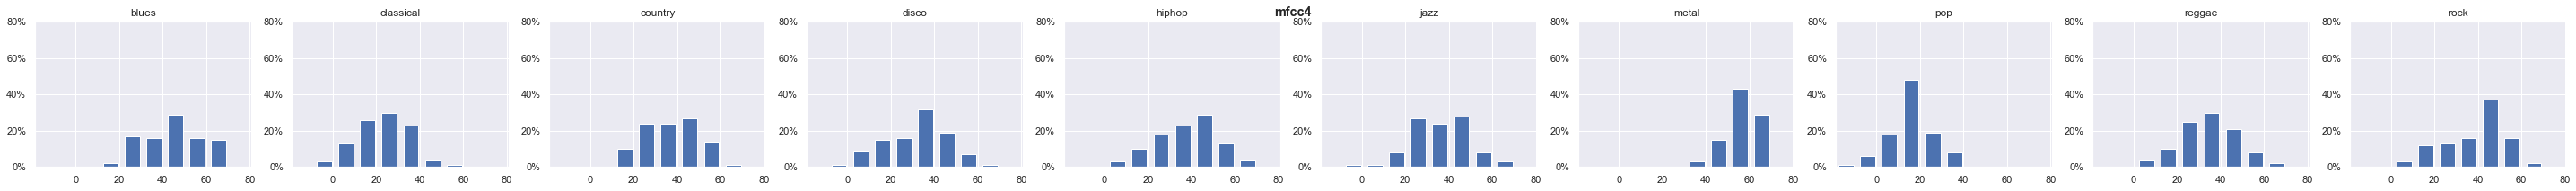

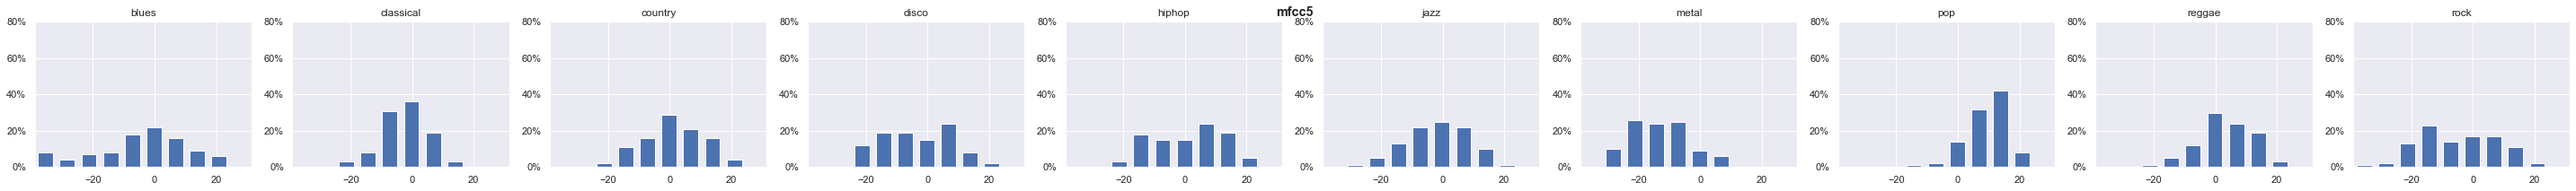

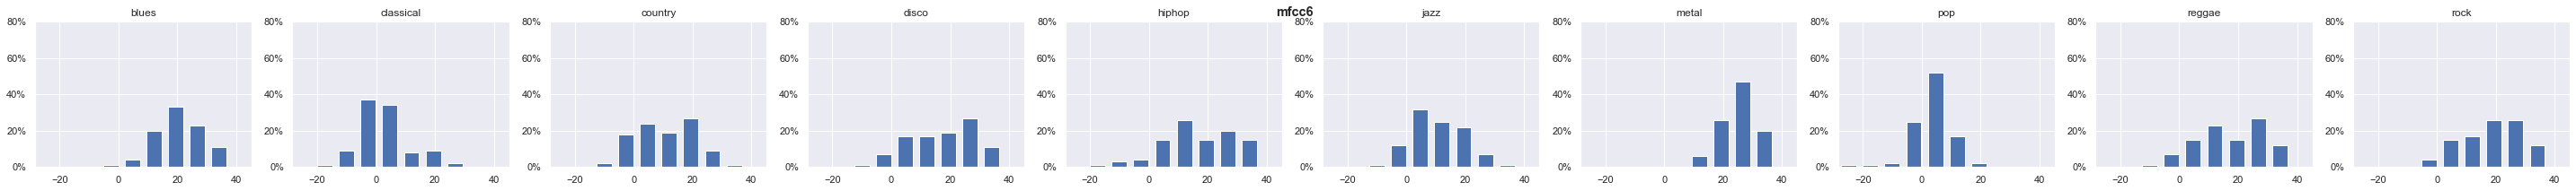

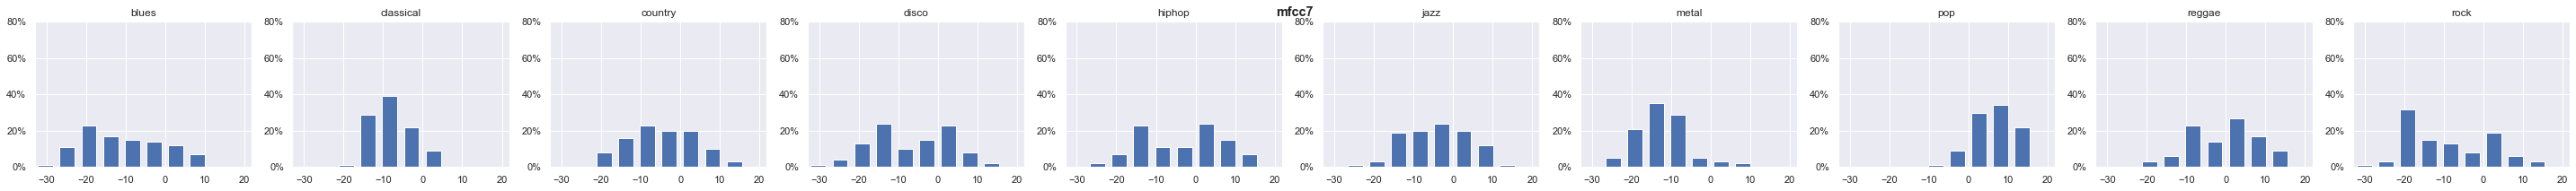

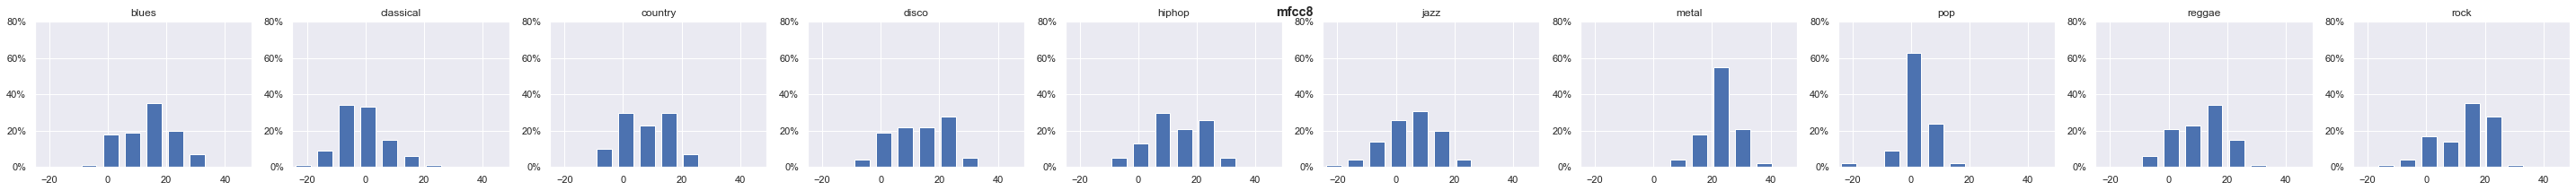

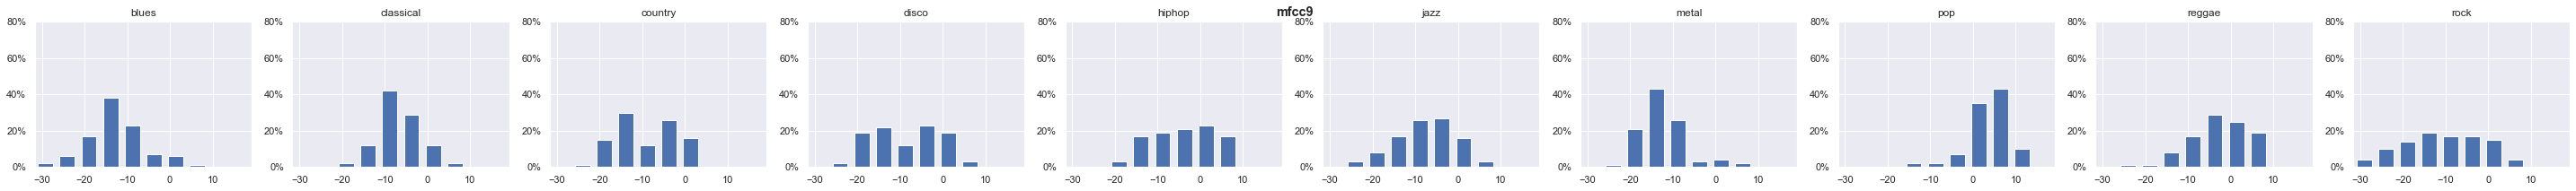

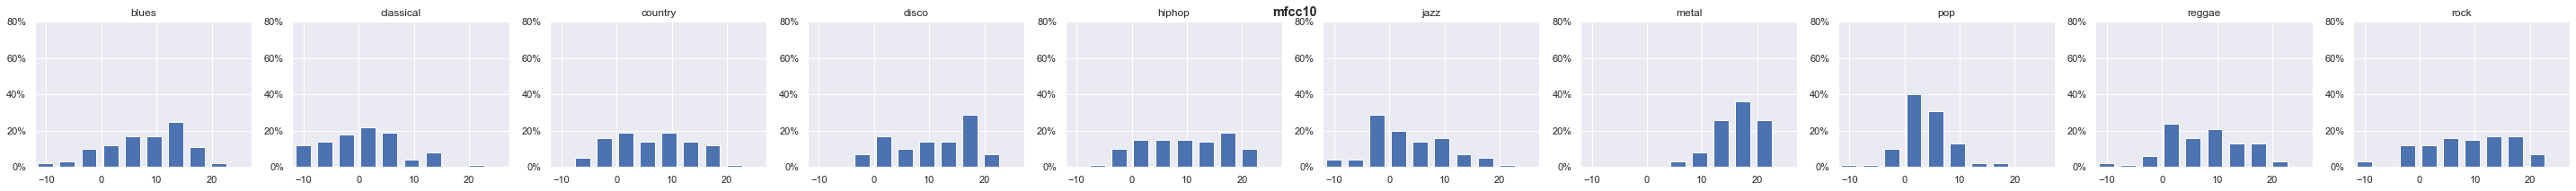

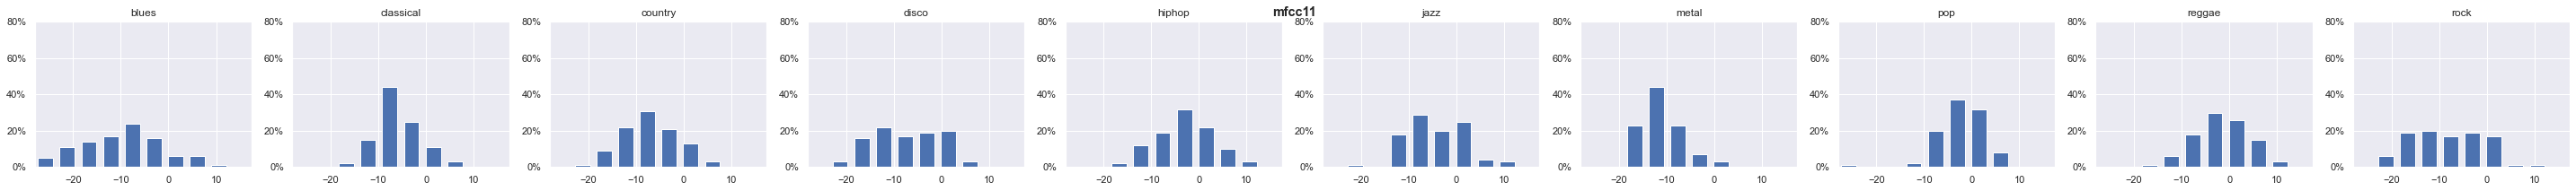

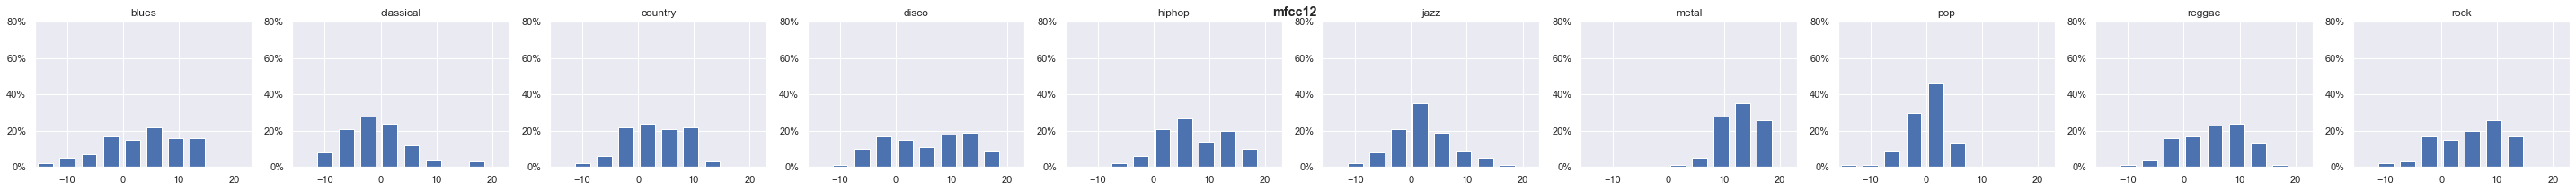

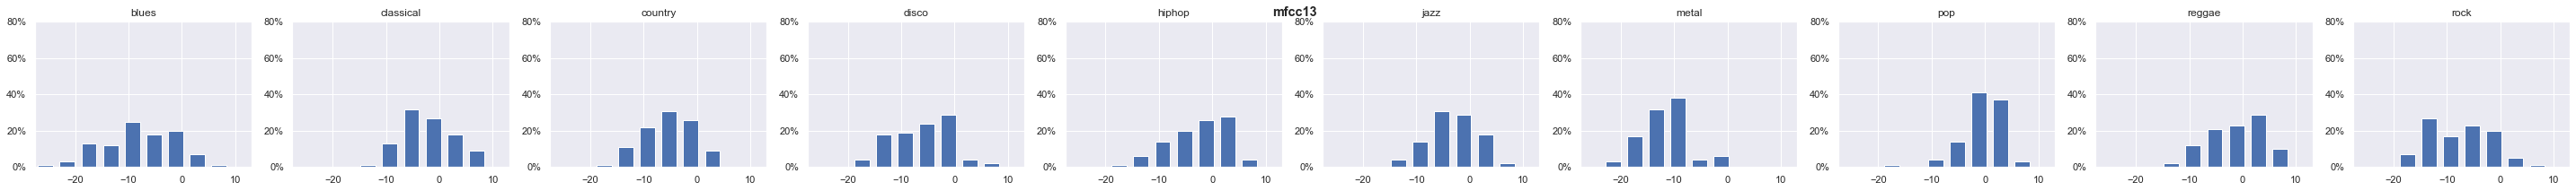

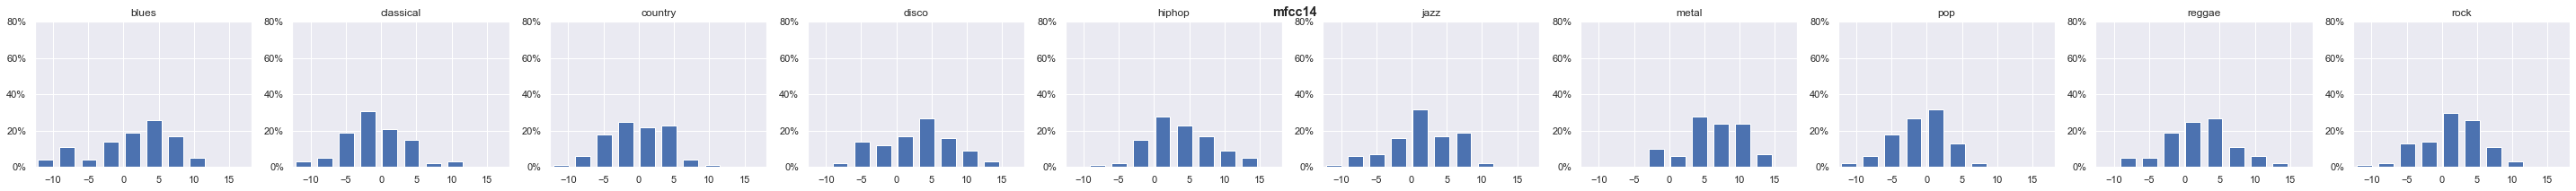

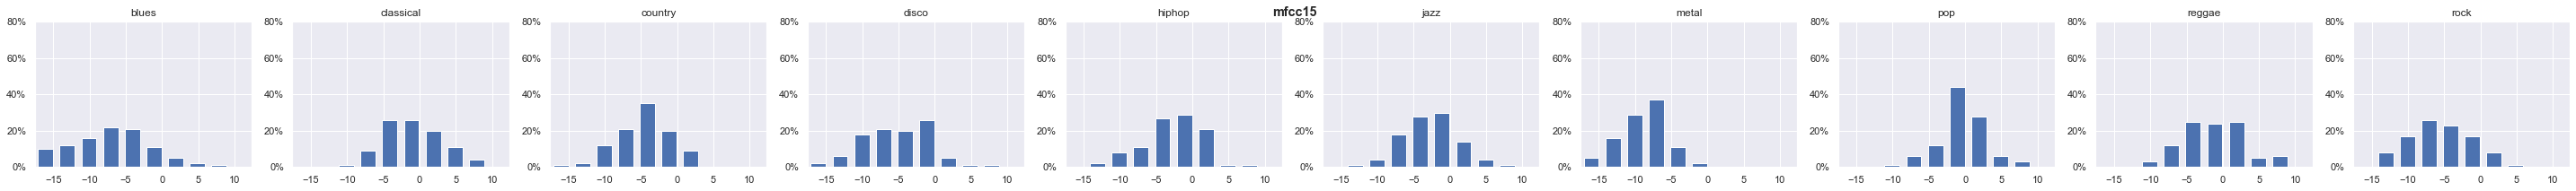

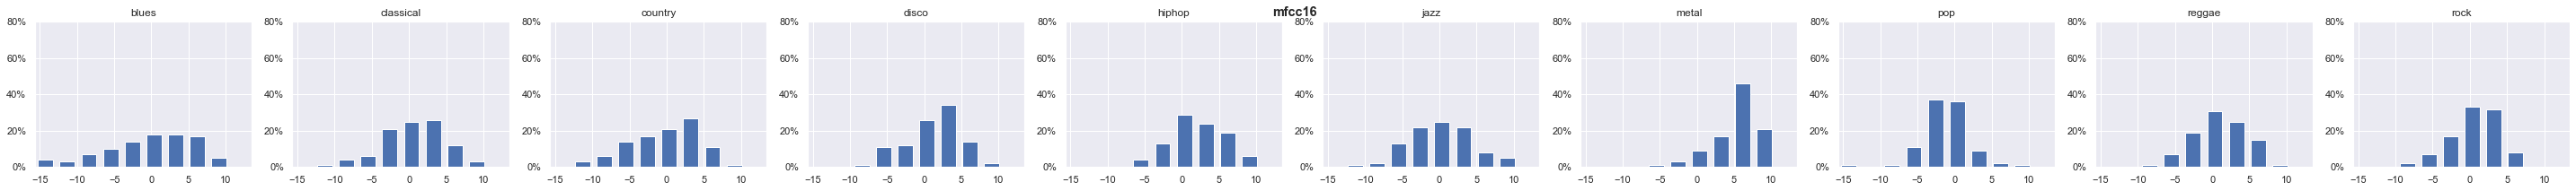

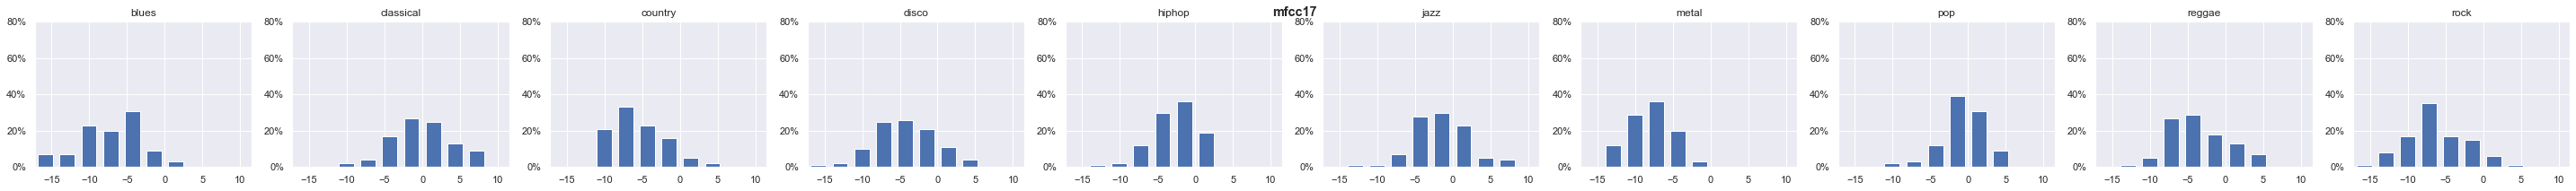

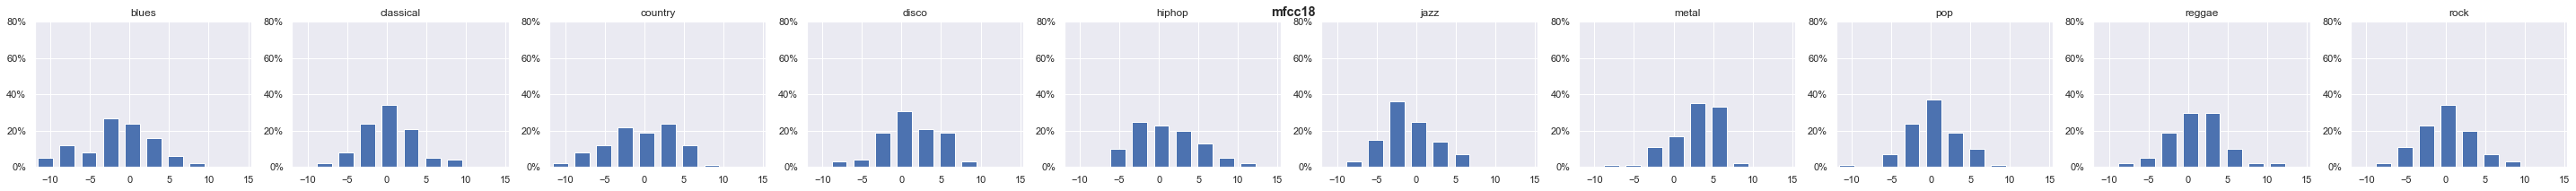

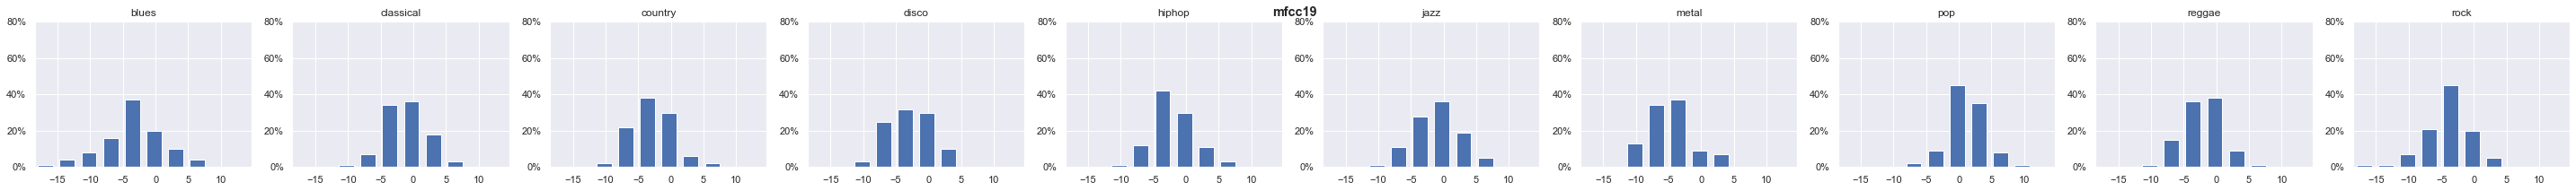

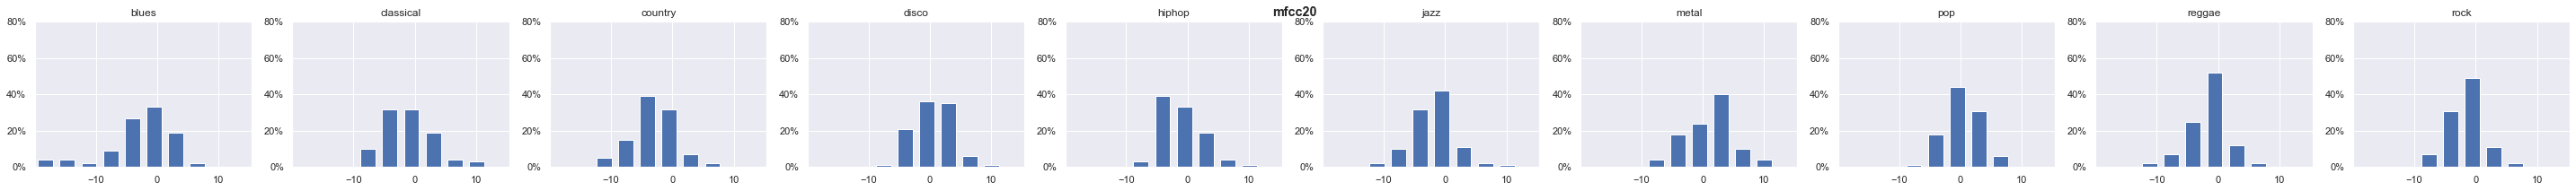

In [58]:
for i in range (1,len(header)-1):
  plot_hists(header[i], 0.8)

pl.rc('figure', max_open_warning = 0)

In [59]:
dataFrameMedVar = pd.DataFrame({})
temp = pd.DataFrame({})
dataFrameMedVarTot = pd.DataFrame({}) 
for i in range (1,len(header)-1):
  mediane = []
  iqrang = []
  for j in labels:
    mediane.append(generalStatist(header[i],label=j)["mediana"])
    iqrang.append(generalStatist(header[i],label=j)["iqr"])
  dataFrameMedVar["Value"] = mediane
  dataFrameMedVar["Type"] = "Median"
  dataFrameMedVar["Feature"] = header[i]
  temp["Value"] = iqrang
  temp["Type"] = "IQR"
  temp["Feature"] = header[i]
  dataFrameMedVarTot=dataFrameMedVarTot.append(dataFrameMedVar.append(temp))



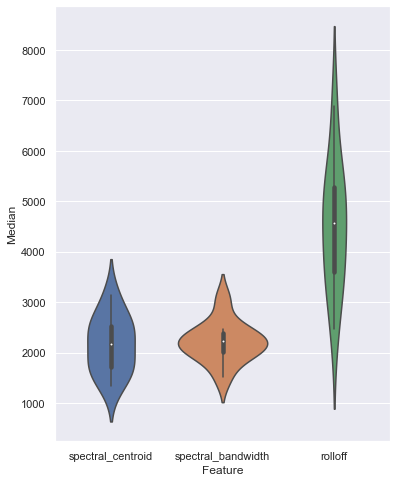

In [60]:
ax = sns.violinplot(x="Feature", y="Value",
                    data=dataFrameMedVarTot[dataFrameMedVarTot["Type"]== "Median"], order = ["spectral_centroid", "spectral_bandwidth", "rolloff"])
ax.set_ylabel("Median")
sns.set(rc = {'figure.figsize':(6,8)})

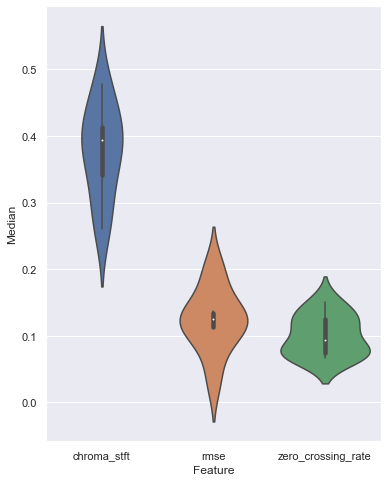

In [61]:
a =  [header[1]]
a.append(header[2])
a.append(header[6])
ax = sns.violinplot(x="Feature", y="Value",
                    data=dataFrameMedVarTot[dataFrameMedVarTot["Type"]== "Median"], order = a)
ax.set_ylabel("Median")
sns.set(rc = {'figure.figsize':(6,8)})

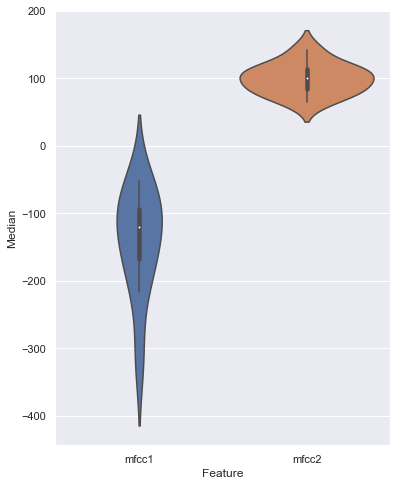

In [62]:
a =  header[7:9]

ax = sns.violinplot(x="Feature", y="Value",
                    data=dataFrameMedVarTot[dataFrameMedVarTot["Type"]== "Median"], order = a)
ax.set_ylabel("Median")
sns.set(rc = {'figure.figsize':(4,8)})

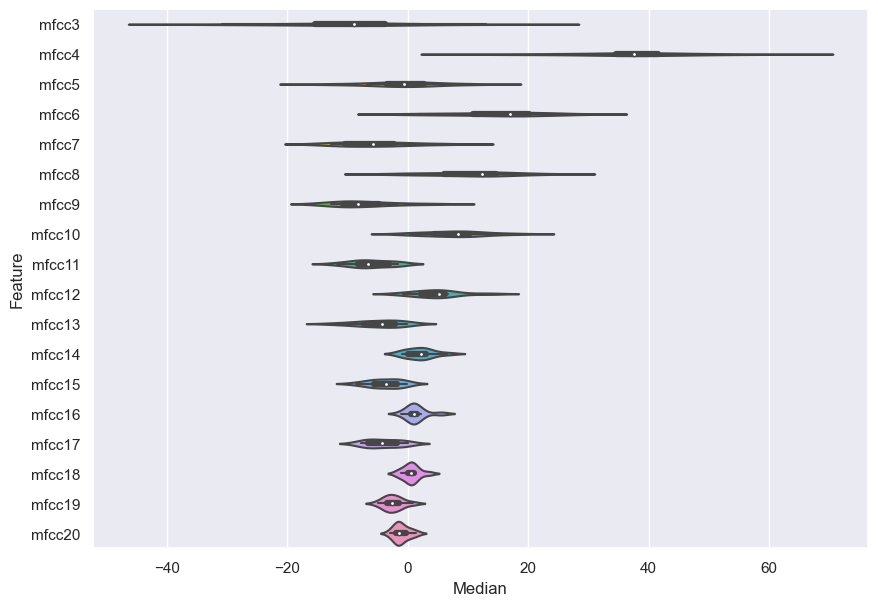

In [143]:
a =  header[9:27]

ax = sns.violinplot(x="Value", y="Feature",
                    data=dataFrameMedVarTot[dataFrameMedVarTot["Type"]== "Median"], order = a)
ax.set_xlabel("Median")
sns.set(rc = {'figure.figsize':(20,7)})

In [141]:
percOut =pd.DataFrame(np.nan, index=[0], columns=header[1:6])


for i in range (1,7):
  out = outliers(originaldata[header[i]])
  percOut[header[i]] = len(out)/len(originaldata[header[i]])*100
percOut

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate
0,0.3,0.5,0.1,0.1,0.0,0.6


In [65]:
percOut =pd.DataFrame(np.nan, index=[0], columns=header[7:27])


for i in range (7,27):
  out = outliers(originaldata[header[i]])
  percOut[header[i]] = len(out)/len(originaldata[header[i]])*100
percOut

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2.7,0.4,0.5,0.1,0.2,0.1,0.0,0.2,0.1,0.0,0.3,0.0,0.1,0.4,0.4,0.9,0.9,1.2,1.5,2.3


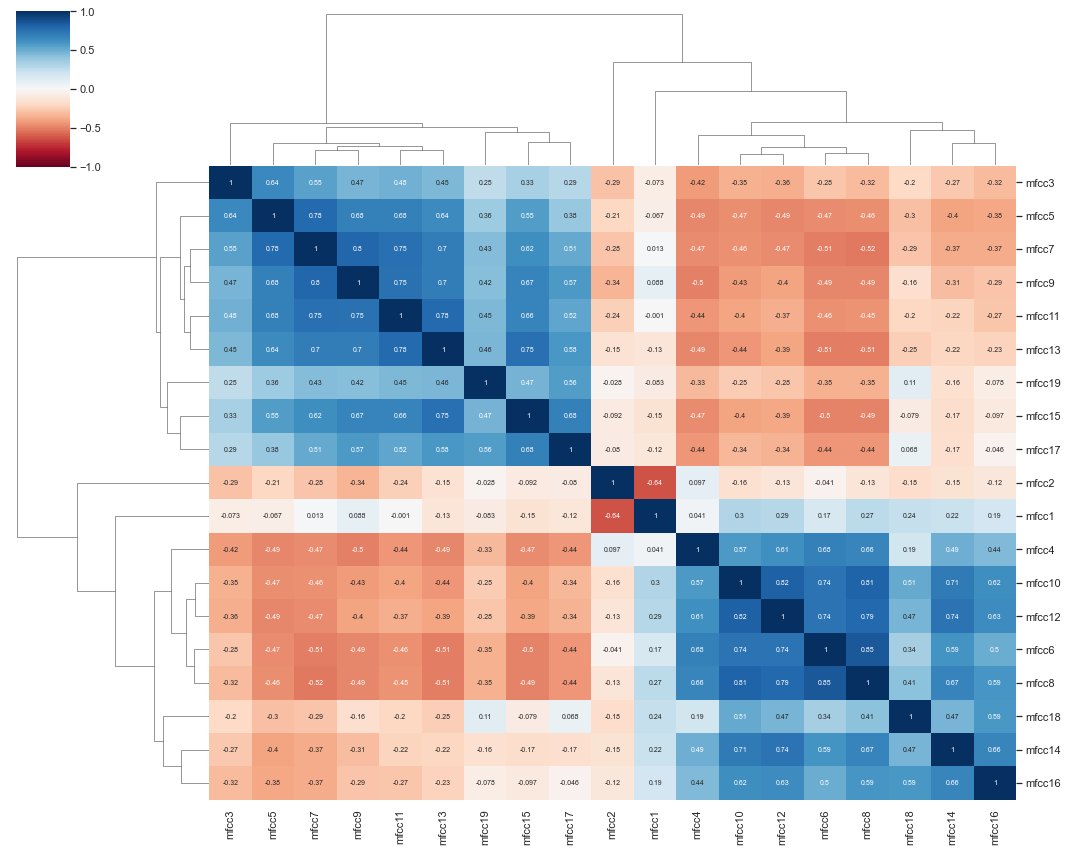

In [66]:
#mfccs correlation
matrix = correlation(originaldata.iloc[:, 7:26])
ax_corr = sns.clustermap(matrix, method="average", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12))

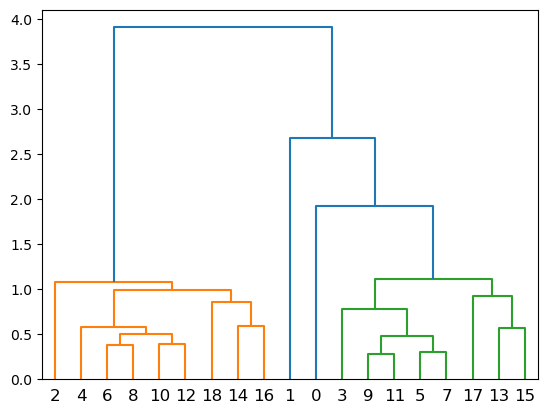

In [67]:
data_dist = pdist(matrix, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
sns.reset_defaults() 
res = dendrogram(data_link, color_threshold=1.2)

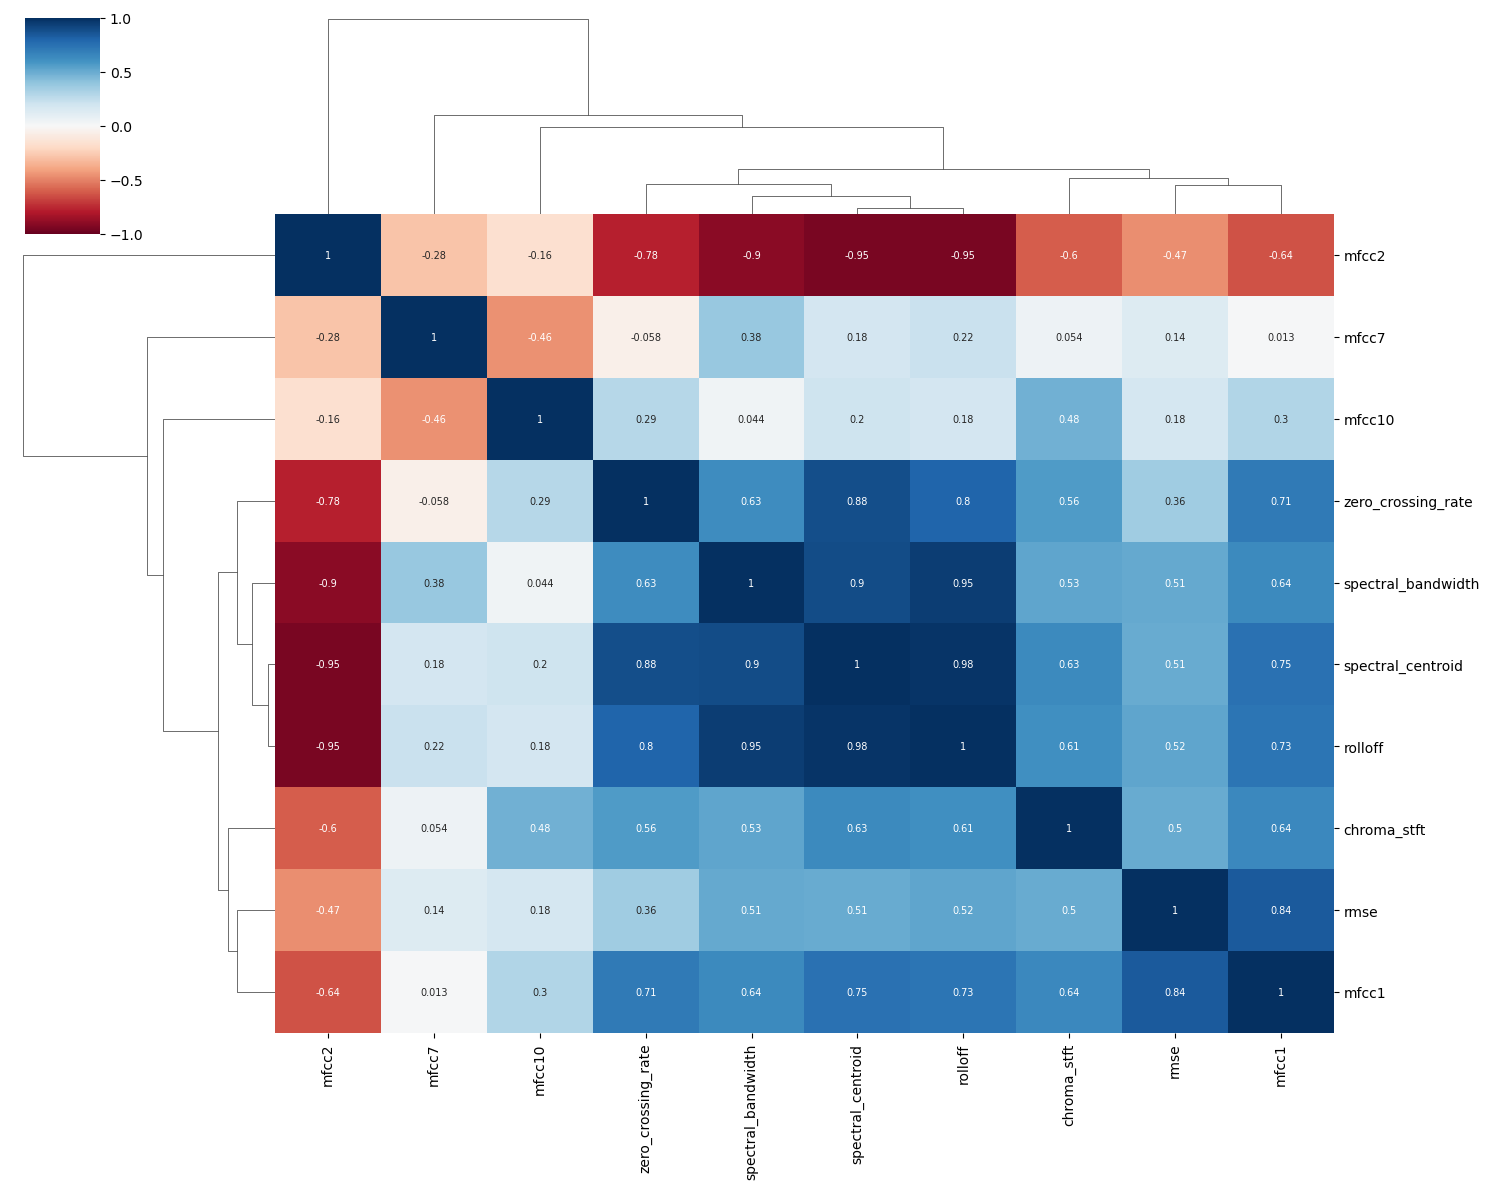

In [68]:
#total correlations
toKeep = [1,2,3,4,5,6,7,8,13,16]
matrix_tot = correlation(originaldata.iloc[:, toKeep])
ax_corr = sns.clustermap(matrix_tot, method="average", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12))

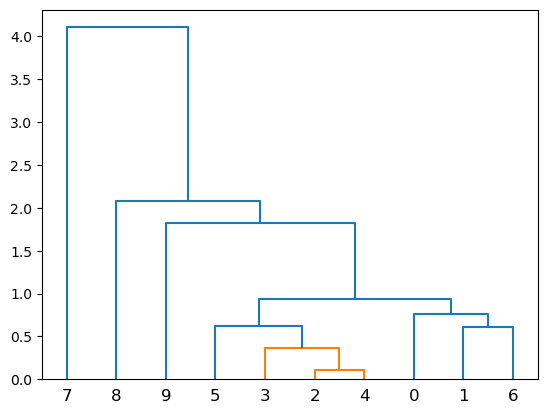

In [69]:
data_dist = pdist(matrix_tot, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')

res = dendrogram(data_link, color_threshold=0.4)


**kmeans**

In [70]:
cols = ['chroma_stft','rmse','rolloff','zero_crossing_rate','mfcc1','mfcc2','mfcc7','mfcc10']
X= originaldata[cols].values
X

array([[ 3.49943221e-01,  1.30224630e-01,  3.80648532e+03, ...,
         1.21557297e+02, -1.36979122e+01,  1.09804916e+01],
       [ 3.40983123e-01,  9.59184244e-02,  3.54882021e+03, ...,
         1.24006721e+02, -8.55470371e+00,  1.19037437e+01],
       [ 3.63602877e-01,  1.75573036e-01,  3.04051495e+03, ...,
         1.40459900e+02, -1.36495848e+01,  9.70644283e+00],
       ...,
       [ 4.32103455e-01,  8.16166848e-02,  4.03076729e+03, ...,
         1.15194977e+02, -1.24187546e+01,  1.01133270e+01],
       [ 3.62349004e-01,  8.38877931e-02,  3.01474010e+03, ...,
         1.23656891e+02, -1.02502060e+01,  1.27962265e+01],
       [ 3.58195126e-01,  5.44607304e-02,  3.24628037e+03, ...,
         1.23888542e+02, -7.05967855e+00,  1.67044182e+01]])

In [71]:
scaler = StandardScaler()
X_scal = scaler.fit_transform(X)
X_scal

array([[-0.35174846, -0.01072298, -0.48616606, ...,  0.7026738 ,
        -0.86229008,  0.40965949],
       [-0.46146639, -0.53326615, -0.64986871, ...,  0.78088961,
        -0.34469107,  0.52602593],
       [-0.18448365,  0.68001209, -0.97281085, ...,  1.30627776,
        -0.85742653,  0.24907874],
       ...,
       [ 0.65431758, -0.75110651, -0.34367274, ...,  0.49951017,
        -0.73355901,  0.30036231],
       [-0.19983754, -0.71651358, -0.98918641, ...,  0.76971871,
        -0.51532197,  0.63851421],
       [-0.25070248, -1.16473892, -0.84208168, ...,  0.77711587,
        -0.19423566,  1.13110159]])

In [72]:
kmeans = KMeans(n_clusters=10, n_init=10, max_iter=100)
kmeans.fit(X_scal)

KMeans(max_iter=100, n_clusters=10)

In [73]:
kmeans.labels_

array([7, 0, 3, 3, 3, 3, 3, 3, 7, 0, 3, 0, 3, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 3, 5, 5, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 5, 7, 7, 9, 7,
       7, 8, 9, 9, 7, 3, 7, 7, 8, 7, 1, 7, 7, 7, 7, 1, 7, 4, 7, 4, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 1, 7, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 3, 3, 3,
       3, 5, 3, 0, 5, 5, 3, 3, 5, 3, 4, 3, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 3, 5, 5, 3, 3, 5, 3, 9, 5, 8, 9, 3,
       3, 5, 3, 5, 5, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 2, 2, 9, 2, 2, 2, 2, 2, 2, 6, 3, 9, 3, 9, 9, 3, 3, 3, 9, 5,
       9, 3, 3, 5, 3, 3, 3, 9, 3, 3, 5, 9, 8, 9, 9, 8, 5, 9, 9, 6, 9, 9,
       9, 9, 8, 2, 9, 9, 8, 3, 0, 0, 0, 7, 0, 7, 0, 0, 7, 3, 0, 0, 7, 0,
       3, 5, 7, 5, 3, 0, 7, 3, 7, 0, 0, 7, 3, 0, 5, 3, 7, 7, 7, 0, 7, 0,
       7, 0, 7, 0, 7, 0, 7, 3, 3, 3, 7, 0, 3, 1, 9,

In [74]:
centers = kmeans.cluster_centers_
centers

array([[-0.68472555, -0.76826697, -0.68555585, -0.71985553, -0.79157939,
         0.55241982, -0.34411657,  0.63918448],
       [ 1.0123754 ,  1.37476738,  0.29759304,  0.6546324 ,  1.11119534,
        -0.30196408, -0.87092284,  1.14341061],
       [ 0.46101092,  1.06561901,  0.97622185,  0.38742094,  0.79757241,
        -0.92195751,  0.97673752, -0.3894773 ],
       [-0.82598389,  0.00819411, -0.9910843 , -0.91633491, -0.25890894,
         1.03158872, -0.24819776, -0.87104347],
       [ 1.10857012, -0.3703244 ,  0.4595653 ,  1.14482993,  0.4092283 ,
        -0.58028428, -0.91641848,  1.23329895],
       [-1.37702025, -1.30417396, -1.47795519, -1.00781169, -1.82786561,
         1.4577899 ,  0.03009844, -1.03027474],
       [ 0.72447534,  0.76383823,  1.79588434,  1.71179138,  0.88477419,
        -1.59882996,  1.10806979, -0.48590569],
       [ 0.11425594,  0.07011672, -0.00956892, -0.0372944 ,  0.37324622,
         0.17613777, -1.04123937,  0.86940668],
       [ 0.50679302, -0.07276583

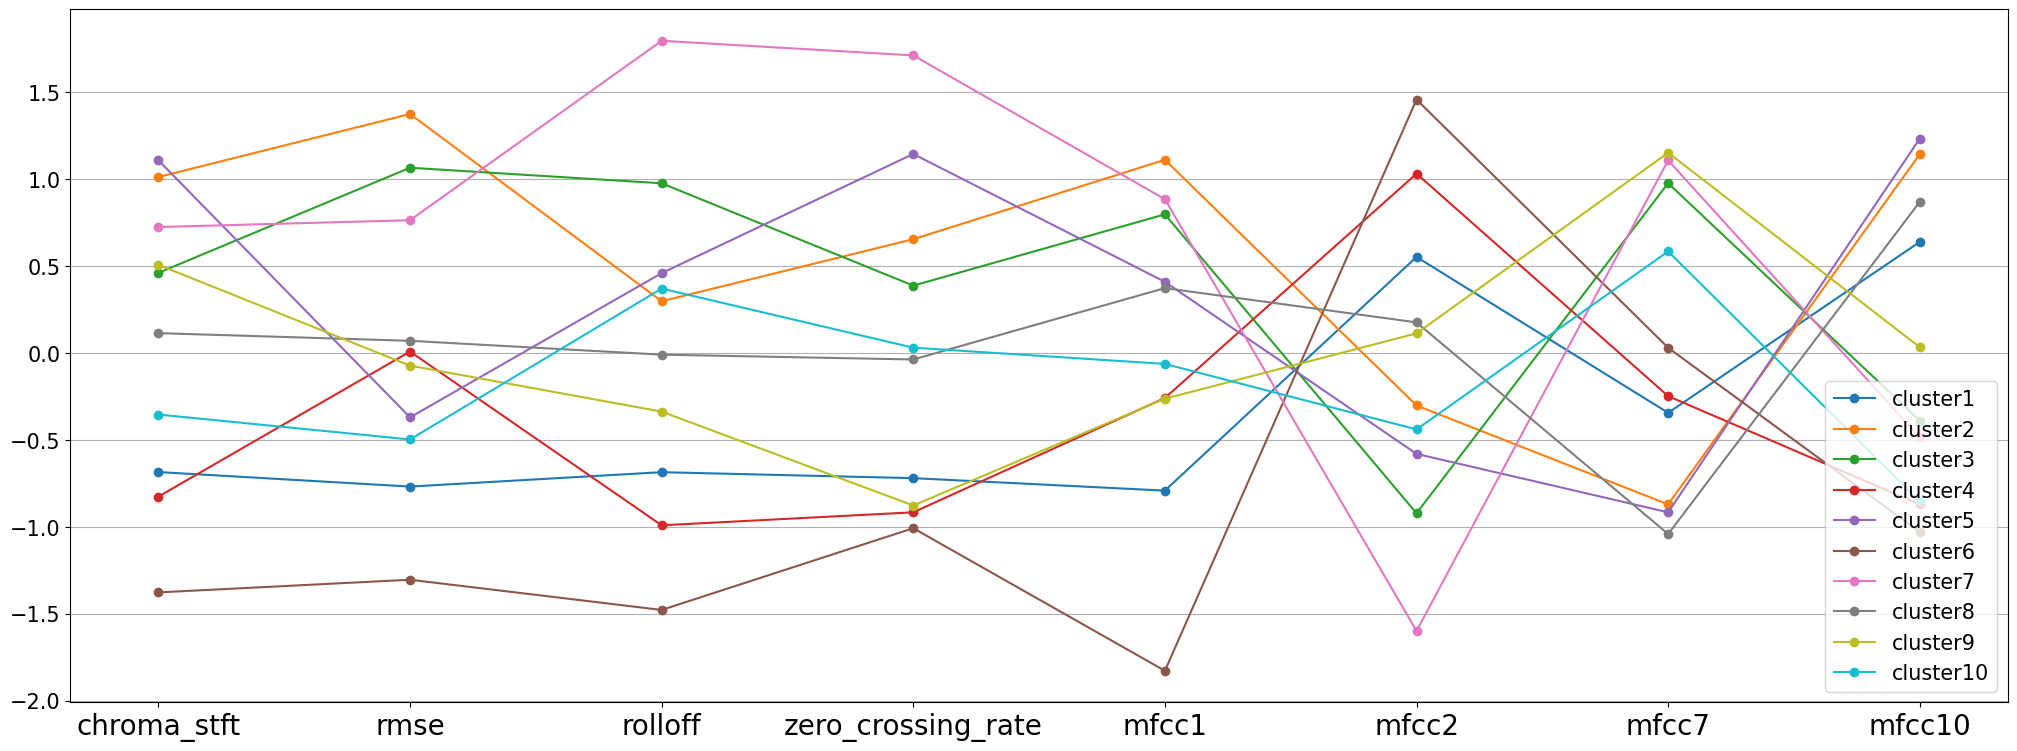

In [75]:
pl.figure(figsize=(25, 9))

for i in range(len(centers)):
    #plt.plot(centers[i], marker='o', label='Cluster %s' % i)
    pl.plot(centers[i], marker='o', label="cluster{}".format(i+1))
    
pl.xticks(range(0, len(cols)), cols, fontsize=20)
pl.yticks(fontsize=15)
pl.grid(axis='y')
pl.legend(fontsize=15, loc='lower right')

pl.show()

In [76]:
Rscaler = RobustScaler()
X_Rscal = Rscaler.fit_transform(X)
X_Rscal

array([[-0.28479855,  0.08721696, -0.39576919, ...,  0.53629513,
        -0.50371055,  0.29966642],
       [-0.36181978, -0.29752352, -0.51543304, ...,  0.59314989,
        -0.17909983,  0.37192161],
       [-0.16737979,  0.59579455, -0.75149822, ...,  0.97505239,
        -0.50066039,  0.19995733],
       ...,
       [ 0.42145295, -0.45791603, -0.29160902, ...,  0.38861632,
        -0.42297723,  0.23180074],
       [-0.17815812, -0.43244579, -0.76346847, ...,  0.5850298 ,
        -0.2861105 ,  0.44176874],
       [-0.21386495, -0.76246719, -0.65593743, ...,  0.59040677,
        -0.08474215,  0.74763007]])

In [77]:
kmeans = KMeans(n_clusters=10, n_init=10, max_iter=100)
kmeans.fit(X_Rscal)

KMeans(max_iter=100, n_clusters=10)

In [78]:
centers = kmeans.cluster_centers_
centers

array([[-0.9996607 , -0.84327519, -1.19312421, -0.68119937, -1.67086578,
         1.20636231,  0.0881141 , -0.66542216],
       [ 0.02950378,  0.05809776, -0.03099938,  0.05136215,  0.04793325,
         0.13682593, -0.63387441,  0.59188418],
       [ 0.45267064,  0.77394034,  1.24534665,  1.12189347,  0.54029056,
        -1.0999672 ,  0.74285435, -0.23607891],
       [-0.81567324, -0.72835343, -0.53140232, -0.34888449, -1.11236402,
         0.32371916, -0.11723181,  0.09546049],
       [-0.14580322, -0.21047231,  0.32525114,  0.17920569, -0.13713293,
        -0.37911265,  0.43687279, -0.42156422],
       [ 0.26679285,  0.90294632,  0.61651721,  0.27720967,  0.44006317,
        -0.60456068,  0.63470326, -0.20133927],
       [ 0.7692356 , -0.16388191,  0.29349908,  0.84322604,  0.14045176,
        -0.39569494, -0.52197264,  0.82250839],
       [ 0.35510176,  0.04946318, -0.29225403, -0.53346576, -0.410934  ,
         0.09623957,  0.67721594,  0.13162306],
       [-0.51465854,  0.08546045

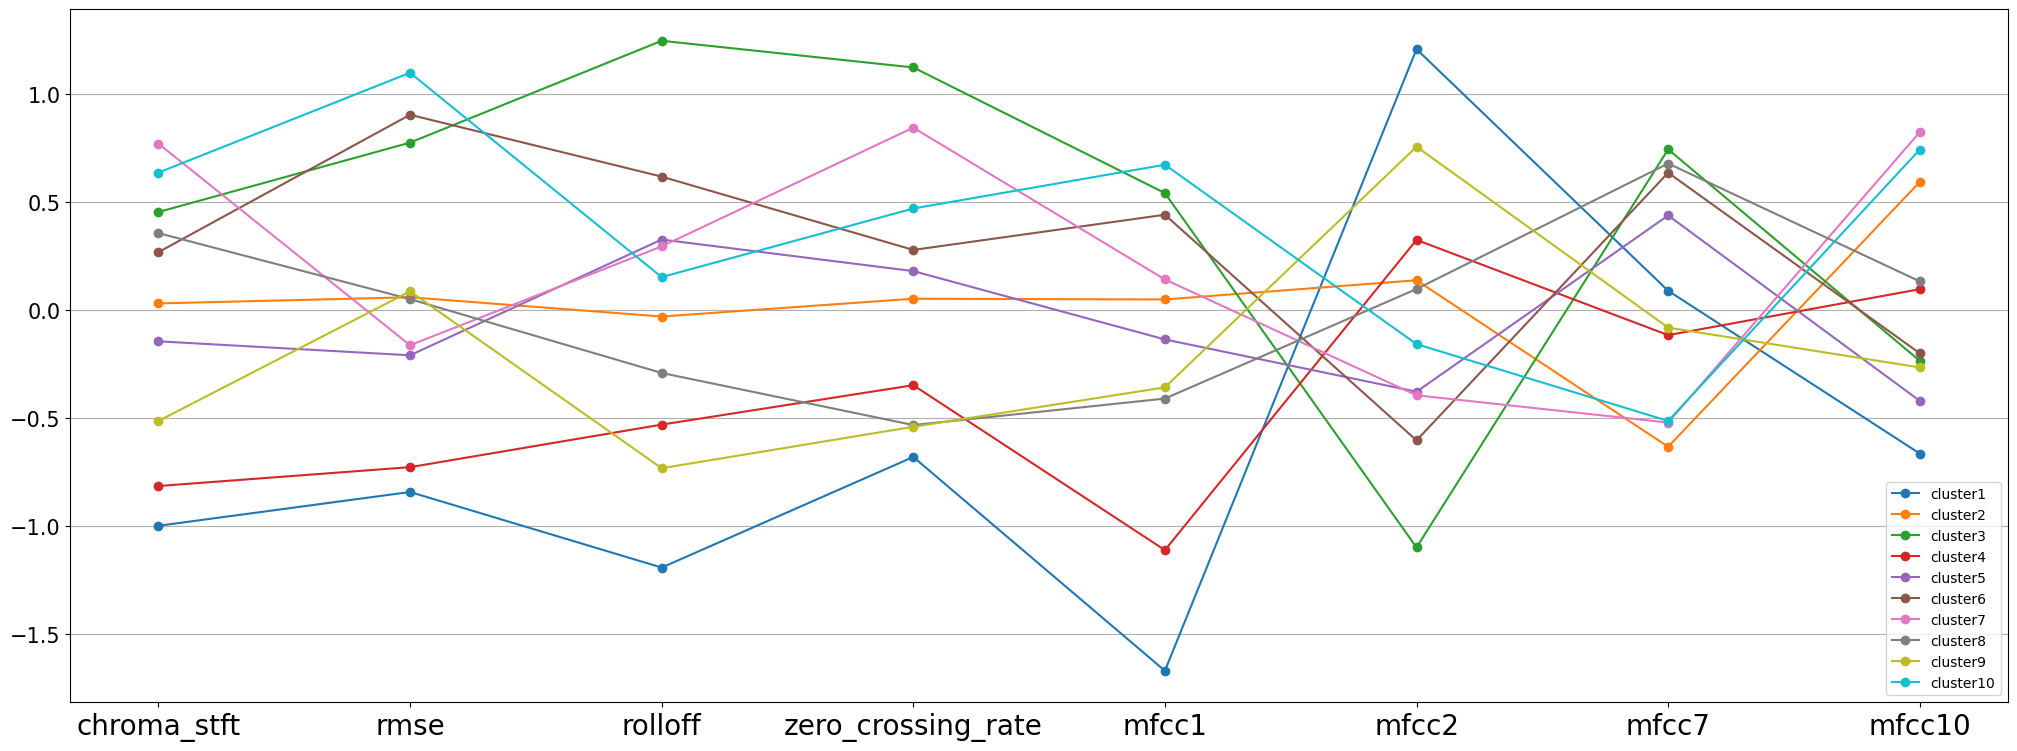

In [79]:
pl.figure(figsize=(25, 9))

for i in range(len(centers)):
    #plt.plot(centers[i], marker='o', label='Cluster %s' % i)
    pl.plot(centers[i], marker='o', label="cluster{}".format(i+1))
    
pl.xticks(range(0, len(cols)), cols, fontsize=20)
pl.yticks(fontsize=15)
pl.grid(axis='y')
pl.legend(fontsize=10, loc='lower right')

pl.show()

In [80]:
clust_name = []
for i in range(len(centers)):
  clust_name.append("cluster{}".format(i+1))
clust_name

['cluster1',
 'cluster2',
 'cluster3',
 'cluster4',
 'cluster5',
 'cluster6',
 'cluster7',
 'cluster8',
 'cluster9',
 'cluster10']

[]

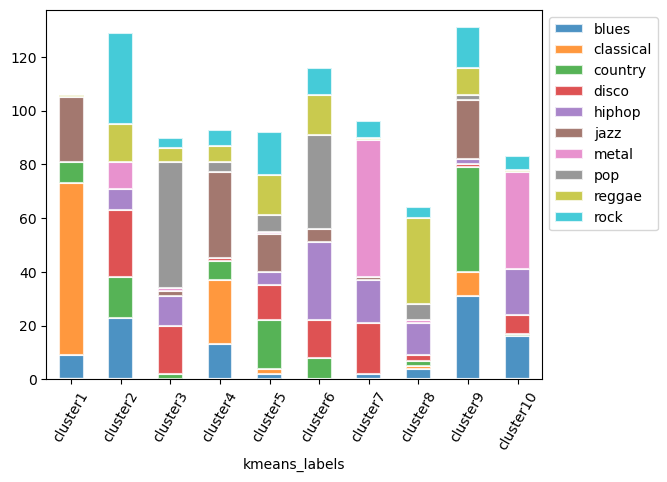

In [81]:

originaldata['kmeans_labels'] = kmeans.labels_ 
bar_pl = originaldata['label'].groupby(originaldata['kmeans_labels']).value_counts(normalize=False).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)


pl.xticks(range(0, len(clust_name)), clust_name, fontsize=10, rotation=60)
pl.yticks(fontsize=10)
pl.legend(bbox_to_anchor=(1,1))
pl.plot()

In [82]:
# SSE & Silhouette

np.unique(kmeans.labels_,return_counts = True)
print("SSE",kmeans.inertia_,"silhouette",silhouette_score(X,kmeans.labels_))

SSE 1081.5647885841504 silhouette -0.034309764458307045


In [83]:
# SSE withX_scal
sse_list = list()
max_k = 50
for k in range(2, max_k + 1):
  kmeans = KMeans(n_clusters=k, n_init=15, max_iter=100)
  kmeans.fit(X_scal)

  sse = kmeans.inertia_
  sse_list.append(sse)

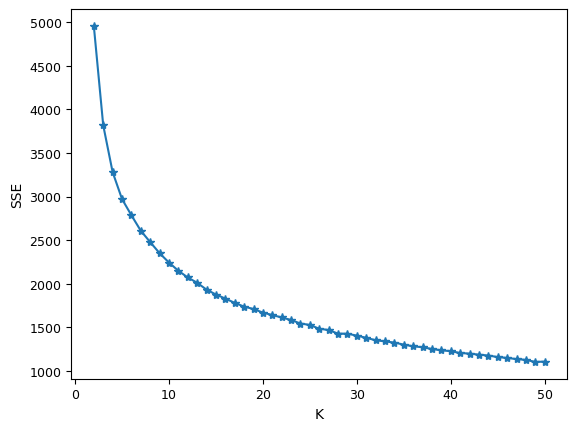

In [84]:
pl.plot(range(2, len(sse_list) + 2), sse_list, marker='*')
pl.ylabel('SSE', fontsize=10)
pl.xlabel('K', fontsize=10)
pl.xticks(fontsize=9)
pl.yticks(fontsize=9)
pl.show()

In [85]:
#  SSE with Rscal 
sse_list = list()
max_k = 50
for k in range(2, max_k + 1):
  kmeans = KMeans(n_clusters=k, n_init=15, max_iter=100)
  kmeans.fit(X_Rscal)

  sse = kmeans.inertia_
  sse_list.append(sse)

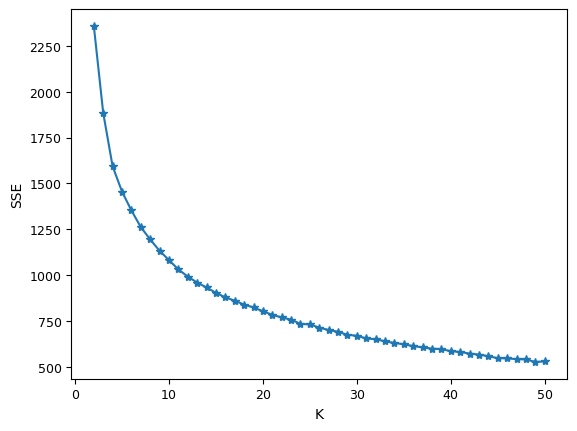

In [86]:
pl.plot(range(2, len(sse_list) + 2), sse_list, marker='*')
pl.ylabel('SSE', fontsize=10)
pl.xlabel('K', fontsize=10)
pl.xticks(fontsize=9)
pl.yticks(fontsize=9)
pl.show()

[]

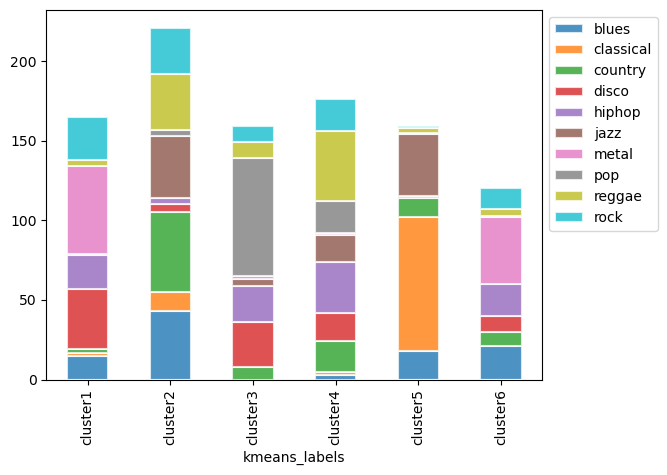

In [87]:
kmeans = KMeans(n_clusters=6, n_init=15, max_iter=100)
kmeans.fit(X_Rscal)
centers = kmeans.cluster_centers_
clust_name = []
for i in range(len(centers)):
  clust_name.append("cluster{}".format(i+1))
originaldata['kmeans_labels'] = kmeans.labels_ 
bar_pl = originaldata['label'].groupby(originaldata['kmeans_labels']).value_counts(normalize=False).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)
pl.xticks(range(0, len(clust_name)), clust_name, fontsize=10, rotation=90)
pl.yticks(fontsize=10)
pl.legend(bbox_to_anchor=(1,1))
pl.plot()

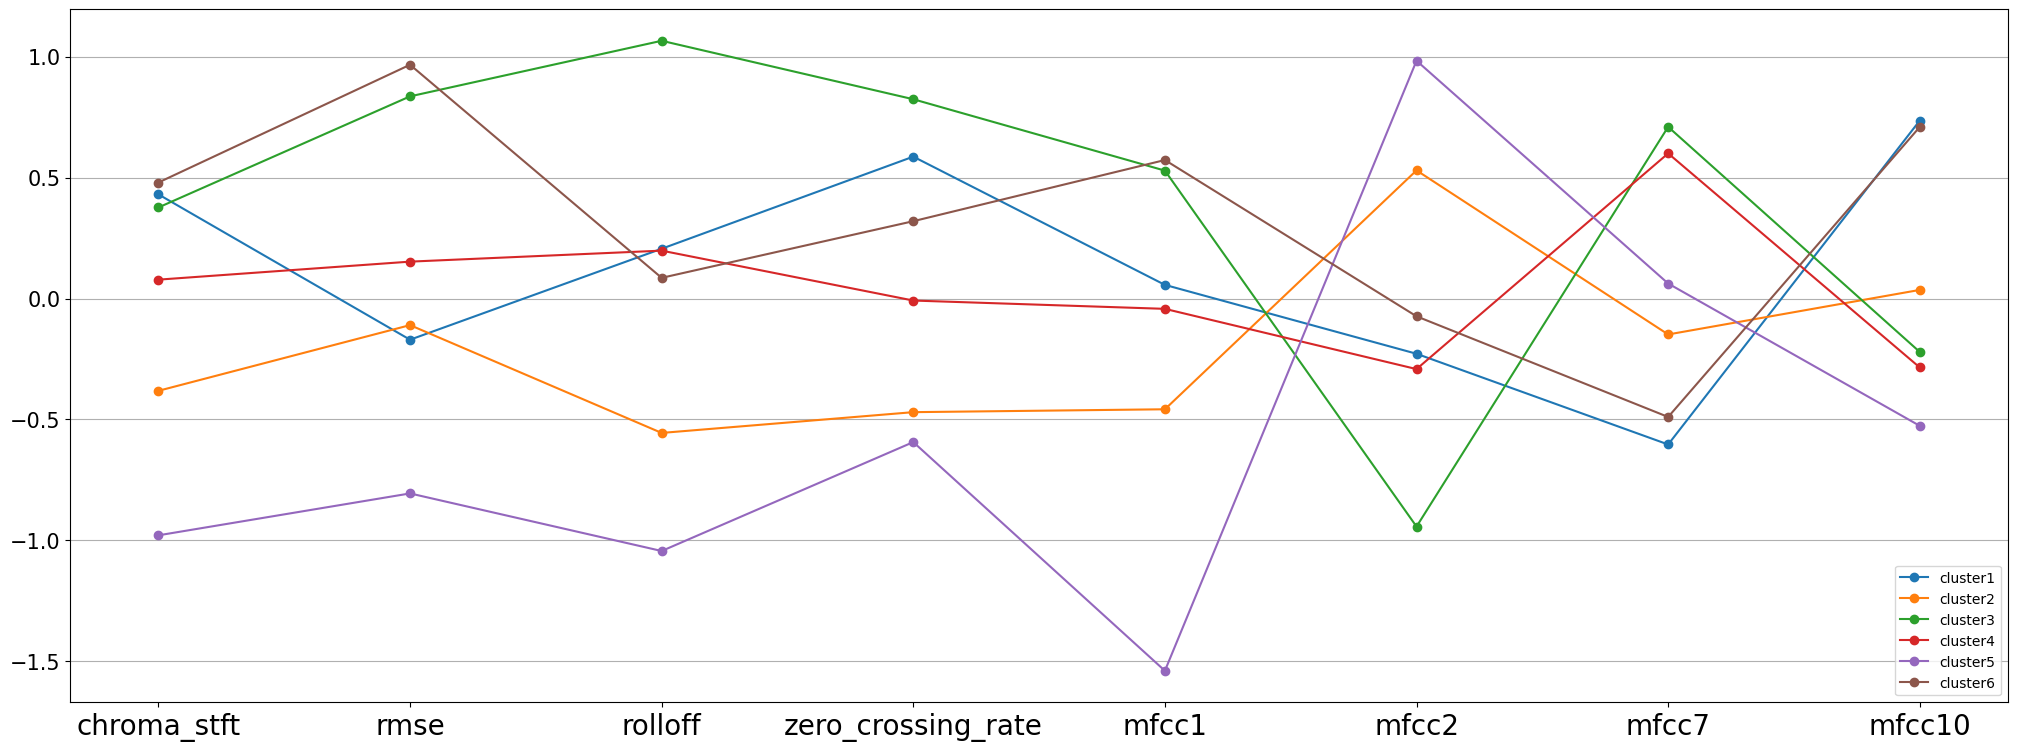

In [88]:
pl.figure(figsize=(25, 9))

for i in range(len(centers)):
    #plt.plot(centers[i], marker='o', label='Cluster %s' % i)
    pl.plot(centers[i], marker='o', label="cluster{}".format(i+1))
    
pl.xticks(range(0, len(cols)), cols, fontsize=20)
pl.yticks(fontsize=15)
pl.grid(axis='y')
pl.legend(fontsize=10, loc='lower right')

pl.show()

In [89]:
#  SSE & Silhouette

np.unique(kmeans.labels_, return_counts = True)
print("SSE",kmeans.inertia_,"silhouette",silhouette_score(X,kmeans.labels_))

SSE 1350.4177276959697 silhouette 0.0963334581056951


**DBSCAN**

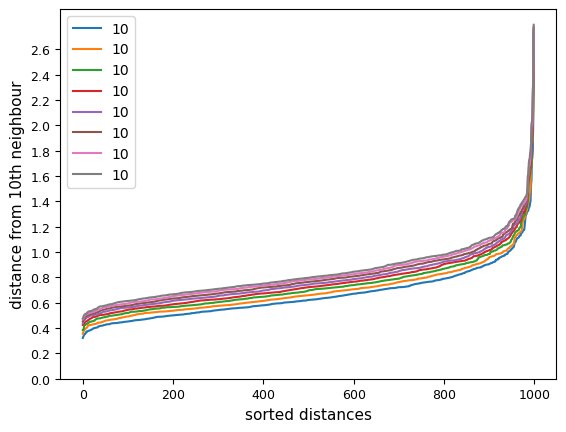

In [90]:
dist = pdist(X_Rscal, "euclidean")
dist = squareform(dist)
for k in range(3,11):
  labelk = []
  distances = []
  for d in dist:
    index = np.argsort(d)[k]
    distances.append(d[index])
    labelk.append(k)
  # plot
  pl.plot(range(0, len(distances)), sorted(distances))
  pl.ylabel('Distance from %sth neighbour' % k, fontsize=11)
  pl.xlabel('sorted distances', fontsize=11)
  pl.xticks(fontsize=9)
  pl.yticks(np.arange(0,2.7,0.2),fontsize=9)
  pl.legend(labelk)
  pl.grid()

In [91]:
dbscan = DBSCAN(eps=0.6, min_samples=5)
dbscan.fit(X_Rscal)
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8}

[]

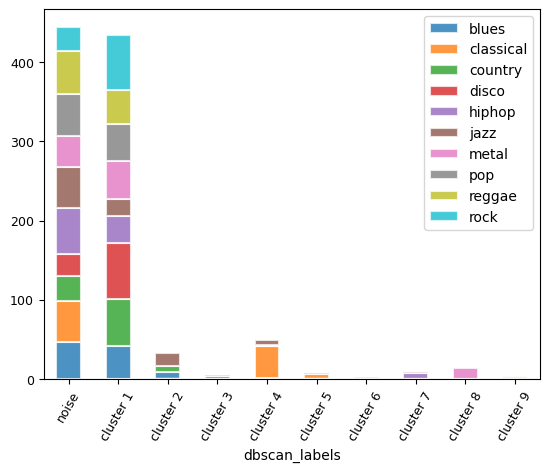

In [92]:
clust_name = ["noise", "cluster 1", "cluster 2", "cluster 3", "cluster 4", "cluster 5", "cluster 6", "cluster 7", "cluster 8", "cluster 9"]

originaldata['dbscan_labels'] = dbscan.labels_ 
bar_pl = originaldata['label'].groupby(originaldata['dbscan_labels']).value_counts(normalize=False).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)
pl.xticks(range(0, len(clust_name)), clust_name, fontsize=9, rotation=60)
pl.yticks(fontsize=9)
pl.legend(bbox_to_anchor=(1,1))
pl.plot()

**CLASSIFICATION**

In [93]:
y = originaldata['label']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
x_train_Rfit = Rscaler.fit(x_train) #questo è il fit basato sul test
x_train_Rscal = x_train_Rfit.transform(x_train)
x_test_Rscal = x_train_Rfit.transform(x_test)

**decision tree**

In [94]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth = None,
                             min_samples_split=10,
                             min_samples_leaf=5) 

In [95]:
scores = cross_val_score(clf,x_train_Rscal,y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, x_train_Rscal,y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.4588 (+/- 0.07)
F1-score: 0.4529 (+/- 0.09)


In [96]:
clf_ent = DecisionTreeClassifier(criterion='entropy',
                             max_depth = None,
                             min_samples_split=10,
                             min_samples_leaf=5) 

clf_ent.fit(x_train_Rscal,y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5,
                       min_samples_split=10)

In [97]:
scores = cross_val_score(clf_ent,x_train_Rscal,y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_ent, x_train_Rscal,y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.4562 (+/- 0.11)
F1-score: 0.4445 (+/- 0.10)


In [98]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth = None,
                             min_samples_split=6,
                             min_samples_leaf=3) 

#clf.fit(x_train_Rscal,y_train)
scores = cross_val_score(clf,x_train_Rscal,y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, x_train_Rscal,y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.4375 (+/- 0.06)
F1-score: 0.4388 (+/- 0.08)


In [99]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth = None,
                             min_samples_split=20,
                             min_samples_leaf=10) 

#clf.fit(x_train_Rscal,y_train)
scores = cross_val_score(clf,x_train_Rscal,y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, x_train_Rscal,y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.4550 (+/- 0.08)
F1-score: 0.4430 (+/- 0.08)


best first

In [100]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth = None,
                             min_samples_split=10,
                             min_samples_leaf=5) 

clf.fit(x_train_Rscal,y_train)

DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=10)

In [101]:
imp_dict = {attr: clf.feature_importances_[i] for i, attr in enumerate(cols)}
imp_dict

{'chroma_stft': 0.18408588341125026,
 'rmse': 0.23046855091452967,
 'rolloff': 0.1445285733203686,
 'zero_crossing_rate': 0.11791377692333548,
 'mfcc1': 0.09154912122173753,
 'mfcc2': 0.0924802833835374,
 'mfcc7': 0.09419927801489575,
 'mfcc10': 0.04477453281034533}

In [102]:
y_pred = clf.predict(x_test_Rscal)

In [103]:
lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [104]:
by_pred = lb.transform(y_pred)
by_pred

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [105]:
fpr = dict()
tpr = dict()
roc_auc = dict()
by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(by_test[:, i], by_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

array([0.70277778, 0.86666667, 0.66944444, 0.65277778, 0.67777778,
       0.55      , 0.83611111, 0.76111111, 0.66111111, 0.51111111])

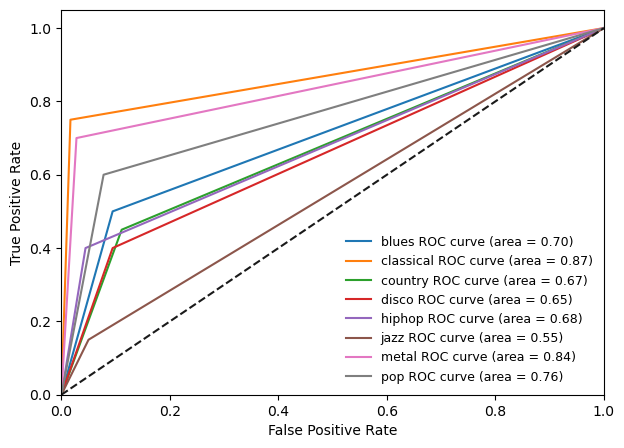

In [106]:
pl.figure(figsize=(7, 5))
for i in range(len(cols)):
    pl.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.05])
pl.xlabel('False Positive Rate', fontsize=10)
pl.ylabel('True Positive Rate', fontsize=10) 
pl.tick_params(axis='both', which='major', labelsize=10)
pl.legend(loc="lower right", fontsize=9, frameon=False)
pl.show()

In [107]:
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

       blues       0.37      0.50      0.43        20
   classical       0.83      0.75      0.79        20
     country       0.31      0.45      0.37        20
       disco       0.32      0.40      0.36        20
      hiphop       0.50      0.40      0.44        20
        jazz       0.25      0.15      0.19        20
       metal       0.74      0.70      0.72        20
         pop       0.46      0.60      0.52        20
      reggae       0.58      0.35      0.44        20
        rock       0.12      0.10      0.11        20

    accuracy                           0.44       200
   macro avg       0.45      0.44      0.44       200
weighted avg       0.45      0.44      0.44       200



In [108]:
choices = {"criterionval": ['gini','entropy'], "n_estimatorsval": [50,60,70,80,90,100,120,140,160,180,200]}
grid = ParameterGrid(choices)
print(len(list(grid)), list(grid))

22 [{'criterionval': 'gini', 'n_estimatorsval': 50}, {'criterionval': 'gini', 'n_estimatorsval': 60}, {'criterionval': 'gini', 'n_estimatorsval': 70}, {'criterionval': 'gini', 'n_estimatorsval': 80}, {'criterionval': 'gini', 'n_estimatorsval': 90}, {'criterionval': 'gini', 'n_estimatorsval': 100}, {'criterionval': 'gini', 'n_estimatorsval': 120}, {'criterionval': 'gini', 'n_estimatorsval': 140}, {'criterionval': 'gini', 'n_estimatorsval': 160}, {'criterionval': 'gini', 'n_estimatorsval': 180}, {'criterionval': 'gini', 'n_estimatorsval': 200}, {'criterionval': 'entropy', 'n_estimatorsval': 50}, {'criterionval': 'entropy', 'n_estimatorsval': 60}, {'criterionval': 'entropy', 'n_estimatorsval': 70}, {'criterionval': 'entropy', 'n_estimatorsval': 80}, {'criterionval': 'entropy', 'n_estimatorsval': 90}, {'criterionval': 'entropy', 'n_estimatorsval': 100}, {'criterionval': 'entropy', 'n_estimatorsval': 120}, {'criterionval': 'entropy', 'n_estimatorsval': 140}, {'criterionval': 'entropy', 'n_e

In [109]:
def get_compiled_model(criterionval, n_estimatorsval):  
  clf = RandomForestClassifier(n_estimators=n_estimatorsval,
                             criterion=criterionval,
                             max_depth=None,
                             min_samples_split=10,  # scegliamo i parametri settati nel decision tree di sopra
                             min_samples_leaf=5,
                             min_weight_fraction_leaf=0.0,
                             max_features='auto'
                            )
  return clf

In [110]:
best_accuracy = 0
best_conf = None
for el in grid:
  print("Training with configuration: ", el["criterionval"], el["n_estimatorsval"])
  scores = cross_val_score(get_compiled_model(el["criterionval"], el["n_estimatorsval"]),x_train_Rscal,y_train, cv=10) 
  
  accuracy = scores.mean()
  print("Accuracy: ", accuracy)
  if accuracy > best_accuracy:
    print("Found better configuration")
    best_accuracy = accuracy
    best_conf = el
print(best_accuracy)
print(best_conf)

Training with configuration:  gini 50
Accuracy:  0.5387500000000001
Found better configuration
Training with configuration:  gini 60
Accuracy:  0.53
Training with configuration:  gini 70
Accuracy:  0.5324999999999999
Training with configuration:  gini 80
Accuracy:  0.5312499999999999
Training with configuration:  gini 90
Accuracy:  0.5362500000000001
Training with configuration:  gini 100
Accuracy:  0.54125
Found better configuration
Training with configuration:  gini 120
Accuracy:  0.52625
Training with configuration:  gini 140
Accuracy:  0.53
Training with configuration:  gini 160
Accuracy:  0.5375
Training with configuration:  gini 180
Accuracy:  0.53375
Training with configuration:  gini 200
Accuracy:  0.5387500000000001
Training with configuration:  entropy 50
Accuracy:  0.5325000000000001
Training with configuration:  entropy 60
Accuracy:  0.54375
Found better configuration
Training with configuration:  entropy 70
Accuracy:  0.5325
Training with configuration:  entropy 80
Accurac

In [111]:
mod = get_compiled_model('entropy', 90).fit(x_train_Rscal,y_train)

In [112]:
imp_dict = {attr: mod.feature_importances_[i] for i, attr in enumerate(cols)}
imp_dict

{'chroma_stft': 0.19841737012409394,
 'rmse': 0.1319610460870416,
 'rolloff': 0.14743120470483434,
 'zero_crossing_rate': 0.10957264442265467,
 'mfcc1': 0.11958862172601455,
 'mfcc2': 0.0945429837609513,
 'mfcc7': 0.11644807982512392,
 'mfcc10': 0.08203804934928577}

In [113]:
y_pred = mod.predict(x_test_Rscal)

In [114]:
lb = LabelBinarizer()
lb.fit(y_test)

LabelBinarizer()

In [115]:
by_pred = lb.transform(y_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(by_test[:, i], by_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc = roc_auc_score(by_test, by_pred, average=None)

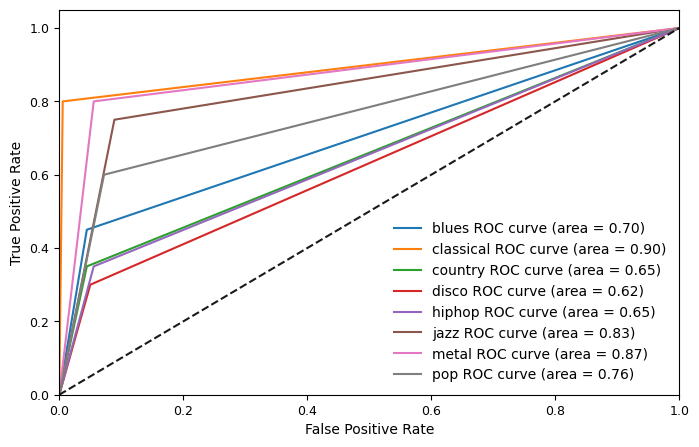

In [119]:
pl.figure(figsize=(8, 5))
for i in range(len(cols)):
    pl.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.05])
pl.xlabel('False Positive Rate', fontsize=10)
pl.ylabel('True Positive Rate', fontsize=10) 
pl.tick_params(axis='both', which='major', labelsize=9)
pl.legend(loc="lower right", fontsize=10, frameon=False)
pl.show()

In [117]:
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

       blues       0.53      0.45      0.49        20
   classical       0.94      0.80      0.86        20
     country       0.47      0.35      0.40        20
       disco       0.40      0.30      0.34        20
      hiphop       0.41      0.35      0.38        20
        jazz       0.48      0.75      0.59        20
       metal       0.62      0.80      0.70        20
         pop       0.48      0.60      0.53        20
      reggae       0.50      0.45      0.47        20
        rock       0.26      0.25      0.26        20

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.50       200

